In [14]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag, pos_tag_sents
from nltk.chunk import ne_chunk
from nltk.corpus import stopwords
from nltk.chunk import ne_chunk_sents
from nltk.tree import Tree
from nltk import download as nltk_download
from tqdm.notebook import tqdm
import pickle
import os
from multiprocessing import Pool
DATA_DIR = 'dataset'

In [1]:
# Read in the data
df = pd.read_csv(f'{DATA_DIR}/full_dataset.csv')

In [2]:
df.head(5)

,Unnamed: 0,title,ingredients,directions,link,source,NER
0,0,No-Bake Nut Cookies,"[""1 c. firmly packed brown sugar"", ""1/2 c. eva...","[""In a heavy 2-quart saucepan, mix brown sugar...",www.cookbooks.com/Recipe-Details.aspx?id=44874,Gathered,"[""brown sugar"", ""milk"", ""vanilla"", ""nuts"", ""bu..."
1,1,Jewell Ball'S Chicken,"[""1 small jar chipped beef, cut up"", ""4 boned ...","[""Place chipped beef on bottom of baking dish....",www.cookbooks.com/Recipe-Details.aspx?id=699419,Gathered,"[""beef"", ""chicken breasts"", ""cream of mushroom..."
2,2,Creamy Corn,"[""2 (16 oz.) pkg. frozen corn"", ""1 (8 oz.) pkg...","[""In a slow cooker, combine all ingredients. C...",www.cookbooks.com/Recipe-Details.aspx?id=10570,Gathered,"[""frozen corn"", ""cream cheese"", ""butter"", ""gar..."
3,3,Chicken Funny,"[""1 large whole chicken"", ""2 (10 1/2 oz.) cans...","[""Boil and debone chicken."", ""Put bite size pi...",www.cookbooks.com/Recipe-Details.aspx?id=897570,Gathered,"[""chicken"", ""chicken gravy"", ""cream of mushroo..."
4,4,Reeses Cups(Candy),"[""1 c. peanut butter"", ""3/4 c. graham cracker ...","[""Combine first four ingredients and press in ...",www.cookbooks.com/Recipe-Details.aspx?id=659239,Gathered,"[""peanut butter"", ""graham cracker crumbs"", ""bu..."


In [3]:
# Extract the directions column as a list of lists of strings
recipes = df['directions'].tolist()
recipes = [eval(recipe) for recipe in tqdm(recipes)]

  0%|          | 0/2231142 [00:00<?, ?it/s]

In [4]:
# Tokenize each recipe into words
# Check if recipe_tokens.pkl exists
if os.path.exists(f'{DATA_DIR}/recipe_tokens.pkl'):
    # load recipe_tokens from a pickle file
    print('Loading recipe_tokens from a pickle file')
    with open(f'{DATA_DIR}/recipe_tokens.pkl', 'rb') as f:
        recipe_tokens = pickle.load(f)
else:
    print('recipe_tokens.pkl does not exist. Creating recipe_tokens...')
    recipe_tokens = [word_tokenize(' '.join(recipe)) for recipe in tqdm(recipes)]
    # save recipe_tokens to a pickle file
    with open(f'{DATA_DIR}/recipe_tokens.pkl', 'wb') as f:
        pickle.dump(recipe_tokens, f)

In [5]:
recipe_tokens[0]

['In',
 'a',
 'heavy',
 '2-quart',
 'saucepan',
 ',',
 'mix',
 'brown',
 'sugar',
 ',',
 'nuts',
 ',',
 'evaporated',
 'milk',
 'and',
 'butter',
 'or',
 'margarine',
 '.',
 'Stir',
 'over',
 'medium',
 'heat',
 'until',
 'mixture',
 'bubbles',
 'all',
 'over',
 'top',
 '.',
 'Boil',
 'and',
 'stir',
 '5',
 'minutes',
 'more',
 '.',
 'Take',
 'off',
 'heat',
 '.',
 'Stir',
 'in',
 'vanilla',
 'and',
 'cereal',
 ';',
 'mix',
 'well',
 '.',
 'Using',
 '2',
 'teaspoons',
 ',',
 'drop',
 'and',
 'shape',
 'into',
 '30',
 'clusters',
 'on',
 'wax',
 'paper',
 '.',
 'Let',
 'stand',
 'until',
 'firm',
 ',',
 'about',
 '30',
 'minutes',
 '.']

In [2]:
# Check if recipe_pos.pkl exists
if os.path.exists(f'{DATA_DIR}/recipe_pos.pkl'):
    # load recipe_pos from a pickle file
    print('Loading recipe_pos from a pickle file')
    with open(f'{DATA_DIR}/recipe_pos.pkl', 'rb') as f:
        recipe_pos = pickle.load(f)
else:
    print('recipe_pos not found. Generating recipe_pos...')
    nltk_download('averaged_perceptron_tagger')
    # Tag each word with its part of speech
    recipe_pos = [pos_tag(tokens) for tokens in tqdm(recipe_tokens)]
    # save to a file
    with open(f'{DATA_DIR}/recipe_pos.pkl', 'wb') as f:
        pickle.dump(recipe_pos, f)

Loading recipe_pos from a pickle file


In [2]:
if os.path.exists(f'{DATA_DIR}/recipe_ner.pkl'):
    # load recipe_ner from a pickle file
    print('Loading recipe_ner from a pickle file')
    with open(f'{DATA_DIR}/recipe_ner.pkl', 'rb') as f:
        recipe_ner = pickle.load(f)
else:
    print('recipe_ner not found. Generating recipe_ner...')
    nltk_download('maxent_ne_chunker')
    nltk_download('words')
    # Perform named entity recognition on each recipe
    # recipe_ner = [ne_chunk(pos) for pos in tqdm(recipe_pos)]
    # Use multiprocessing to speed up the process
    # Get cpu count
    cpu_count = os.cpu_count()
    print(f'Using {cpu_count} CPUs for multiprocessing')
    with Pool() as pool:
        recipe_ner = list(tqdm(pool.imap(ne_chunk, recipe_pos), total=len(recipe_pos)))
    # save to a file
    with open(f'{DATA_DIR}/recipe_ner.pkl', 'wb') as f:
        pickle.dump(recipe_ner, f)

Loading recipe_ner from a pickle file


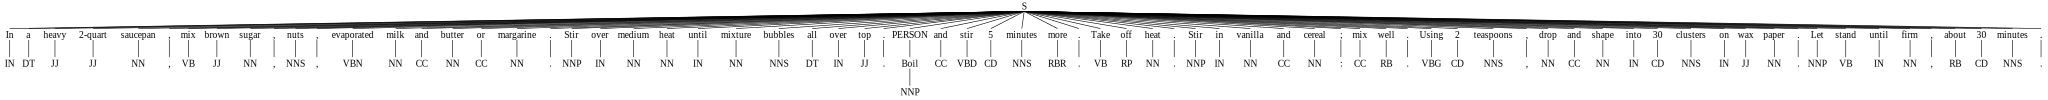

In [13]:
recipe_ner[0]

# What do the keywords like IN, DT, JJ mean?
# https://www.ling.upenn.edu/courses/Fall_2003/ling001/penn_treebank_pos.html
# Which ones are considered as Named Entities?
# https://stackoverflow.com/questions/31836058/nltk-named-entity-recognition-to-a-python-list


In [19]:
def get_continuous_chunks(chunked):
    continuous_chunk = []
    current_chunk = []
    for i in chunked:
        if type(i) == Tree:
            current_chunk.append(" ".join([token for token, pos in i.leaves()]))
        if current_chunk:
            named_entity = " ".join(current_chunk)
            if named_entity not in continuous_chunk:
                continuous_chunk.append(named_entity)
                current_chunk = []
        else:
            continue
    return continuous_chunk

In [22]:
get_continuous_chunks(recipe_ner[0])

['Boil']